# Projet numérique de Science des Données 2025

__Binôme numéro 21__ -- LOSANTOS Solène et MICHAUD Baptiste

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

**Intérêts :**


Dans une région défavorisée, utiliser un algorithme pour prédire le risque obstétrique peut être très utile. Cela permettrait de détecter les grossesses à risque en s’appuyant sur des données simples à mesurer (tension, glycémie, etc.), sans avoir besoin d’examens coûteux ou difficiles à mettre en œuvre. L’algorithme pourrait ainsi aider les soignants à prioriser les cas les plus urgents et à gagner du temps, tout en complétant leur jugement.


**Dérives:**


Cependant, cette approche n’est pas sans risques. Sur le plan éthique, fonder une décision importante (comme poursuivre ou non une grossesse) sur une prédiction algorithmique pose question, surtout si les patientes ne sont pas informées. Il y a aussi un risque de biais si les données utilisées ne représentent qu’une partie de la population. D’un point de vue économique, on pourrait être tenté de réduire les effectifs médicaux pour faire des économies, ce qui serait problématique. Enfin, certaines femmes peuvent mal vivre le fait d’être « évaluées » par une machine, surtout dans un moment aussi sensible que la grossesse.

## Librairies usuelles

In [81]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [82]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


Maintenant effectuons une mini-analyse statistique pour évaluer le jeu de données proposé :

In [83]:
# analyse rapide de la base de données
df_train.describe()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,29.328750,113.38125,76.725000,8.729750,37.079250,74.633750,0.871250
std,11.919869,18.62544,13.982803,3.261953,0.804785,7.845161,0.803418
min,11.500000,65.00000,40.000000,5.900000,36.200000,59.000000,0.000000
25%,20.000000,95.00000,65.000000,6.900000,36.500000,69.000000,0.000000
50%,25.750000,120.00000,80.000000,7.500000,36.900000,75.000000,1.000000
75%,36.000000,125.00000,90.000000,8.025000,37.400000,80.000000,2.000000
max,57.500000,165.00000,105.000000,19.200000,39.500000,91.000000,2.000000


Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [84]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')


# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

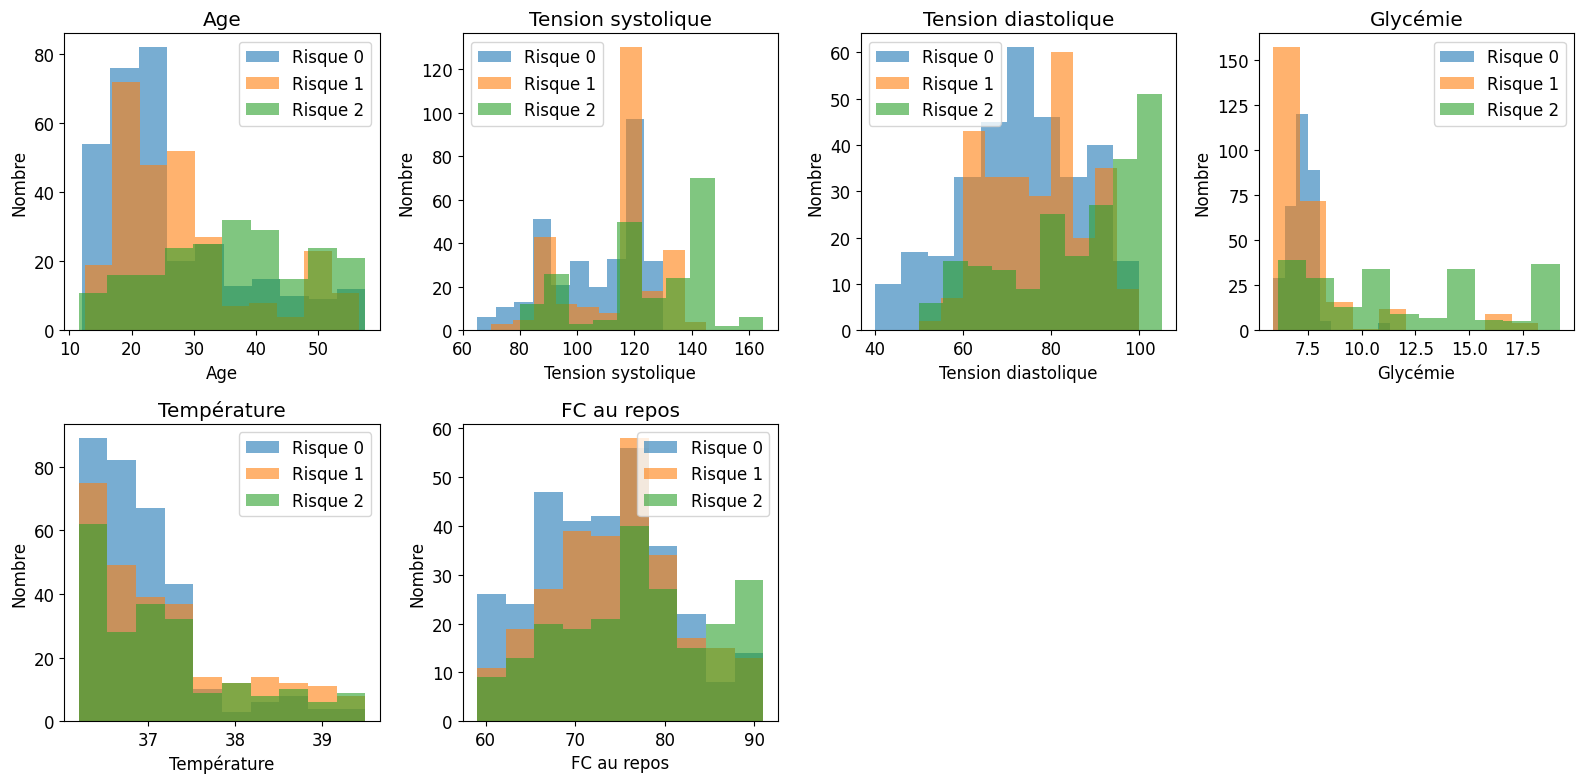

In [85]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
variables = df_train.columns[:-1]  # La dernière colonne est 'Risque'

for idx, variable in enumerate(variables):
    ax = axes[idx]
    for niveau_risque in sorted(np.unique(y_train)):
        donnees = X_train[y_train == niveau_risque, idx]
        ax.hist(donnees, bins=10, alpha=0.6, label=f'Risque {niveau_risque}')
    ax.set_title(variable)
    ax.set_xlabel(variable)
    ax.set_ylabel('Nombre')
    ax.legend()

# Supprimer les axes inutilisés
for k in range(len(variables), len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()


### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

Non les valeurs observées ne sont pas surprenantes. En effet :

- **Age** : Les personnes de degré de risque obstétrique 0 et 1 sont majoritairement jeunes (20-30 ans), tandis que celle de degré 3 couvre tout le spectre des âges et sensiblement plus l'intervalle 30-50 ans. Cela semble cohérent car la fréquence de diabète, d'hypertension et d'autres maladies cardio-vasculaire augmente avec l'âge (moyenne d'âge des patients diabétiques en France : 67,6 ans). Ce résultat semble cohérent avec un raisonnement "avec les mains" : plus une personne est agée, plus elle est suseptible d'avoir un grossesse à risque.

- **Tension systolique, dyastolique et glycémie** : les valeurs les plus élevées de ces variables sont atteintes par des degrés 3 de risque obstétrique. En effet, le diabète se caractérise par un excès de sucre dans le sang (hyperglycémie) et est souvent associé à l'hypertension car ils possèdent les mêmes facteurs de risque (obésité, manque d'activité physique, mauvaise alimentation, tabagisme). 

- **Température** : il semble difficile d'interpréter les valeurs prises par les trois degrés de risque, mais il semble que les degrés 1 et 2 recouvrent plus les températures 38-39°C que le degré 0 qui est très concentré autour de 36-37°C.

- **Fréquence cardiaque au repos** : à nouveau, les valeurs les plus élevées semblent être majoritairement atteintes par des degrés 3 (85-95 battements/minute), bien que les trois degrés couvrent tout le spectre de fréquence cardiaque. 

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

Il va être **difficile** de prédire le risque de grossesse à risque **en utilisant ces 6 variables** ! Certaines variables semblent mieux séparer les trois degrés de risque (notammenent l'âge, les tensions et la glycémie), tandis que d'autres sont moins évidentes à réellement interpréter (température, FC au repos), la distribution des valeurs n'étant pas concentrée autour d'un intervalle précis mais plutôt étalée sur tout le spectre.

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

In [86]:
X = np.array(df_train.drop(columns=['Risque']))

# Standardisation des données
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

(800, 2)


Text(0.5, 1.0, 'Représentation des données selon les 2 composantes principales')

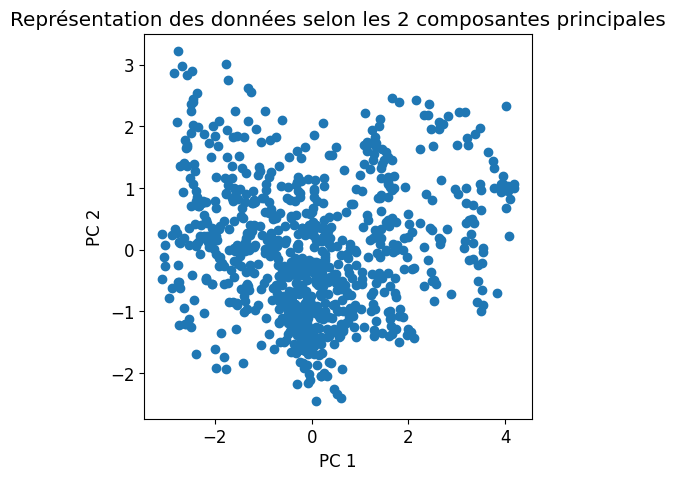

In [87]:
# Calcul de la nouvelle représentation des données (projection sur les 2 composantes principales) :
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)
print(X_projected.shape)

# Affichage du nuage de points représentant les données selon ces deux PC
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_projected[:, 0], X_projected[:, 1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('Représentation des données selon les 2 composantes principales')

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

##### Dans un premier temps, évaluons la proportion cumulative de variance expliquée :

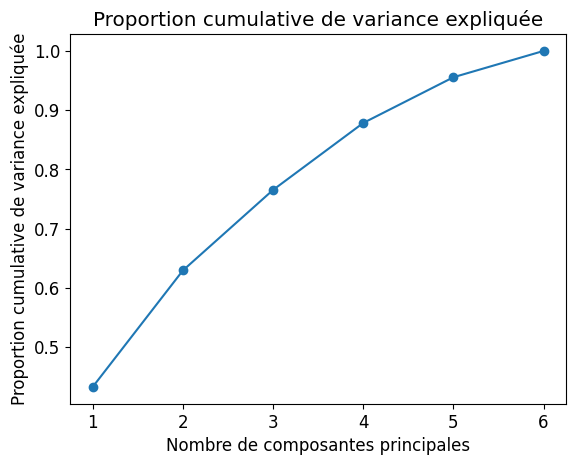

In [88]:
# Instanciation pour 6 composantes principales
pca = decomposition.PCA(n_components=6)
pca.fit(X_scaled)

# Calcul de la proportion cumulative de variance expliquée
variance_cumulative = np.cumsum(pca.explained_variance_ratio_)

# Affichage du graphique
plt.plot(np.arange(1, 7), variance_cumulative, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion cumulative de variance expliquée")
plt.title("Proportion cumulative de variance expliquée")
plt.grid(False)
plt.show()



En observant la courbe de la variance expliquée cumulée, on constate que les trois premières composantes principales à elles seules capturent environ 76,5 % de la variance totale. Cela laisse penser qu’elles pourraient suffire à représenter l’essentiel de l’information pour prédire le risque de grossesse difficile.Au-delà de la quatrième composante, les gains deviennent de plus en plus faibles, ce qui suggère qu’il serait pertinent de limiter l’analyse à ces quatre dimensions.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

Text(0.5, 1.0, 'Matrice de corrélation entre les 6 variables')

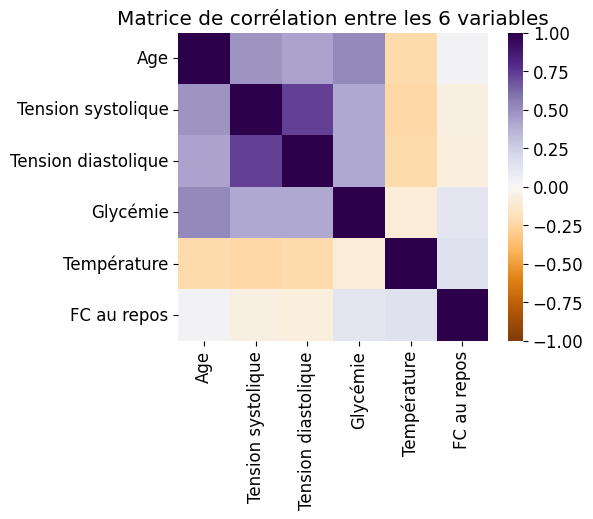

In [89]:
import seaborn as sns

# Calcul de la matrice de corrélation deux à deux
corr_matrix = df_train.drop(columns=['Risque']).corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Matrice de corrélation entre les 6 variables")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

Comme nous l'avions observé à la question 3, l'âge, la tension systolique et diastolique ainsi que la glycémie semblent corrélées entre elles, avec des coefficients compris entre 0,25 et 0,75. À l’inverse, la température et la fréquence cardiaque au repos sont peu ou pas corrélées aux autres variables (coefficients inférieurs à 0,25 en valeur absolue), ce qui signifie qu’elles apportent une information différente.

**Il peut donc être intéressant d’envisager de supprimer la température et la fréquence cardiaque au repos pour réduire la dimension des données, tout en gardant à l’esprit que la tension systolique et diastolique sont très fortement corrélées (coefficient supérieur à 0,7 en module). Il serait donc possible de retirer l’une des deux - voire les deux- sans perdre beaucoup d’information.**

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [90]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')


## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

L'*accuracy* de ce modèle correspondrait exactement à la proportion de la classe majoritaire dans les données. 

$$\text{Accuracy} = \frac{\text{Nombre d'observations correspondant à la classe majoritaire}}{\text{Nombre d'observations total}}$$

Cela serait très embêtant dans le cadre de notre modèle. Si les degrés de risque 1 ou 2 sont plus rares que le degré de type 0, le modèle prédira que toutes les femmes enceintes ont un risque obstrétique de degré 0 indépendemment des données médicales récupérées (âge, tensions, glycémie..). 

**Le modèle sera donc incapable de se servir des données pour prédire correctement le risque. Pourtant, il aura une accuracy élevé!**

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

L’accuracy mesure la proportion globale d’observations correctement classées. Cependant, elle peut être trompeuse lorsque la classe d’intérêt, comme le risque obstétrique élevé, est très minoritaire. Par exemple, si seulement 1 % des cas présentent un fort risque et que l’algorithme ne les détecte pas du tout, l’accuracy ne baissera que d’environ 1 %, ce qui masque une mauvaise performance sur cette classe critique.

La précision équilibré est la moyenne arithmétique du **rappel** (taux de vrais positifs = proportion d’exemples positifs correctement identifiés comme tels) et de la **spécifité** (taux de vrais négatifs = proportion d'exemples négatifs correctement identifiés comme tels).

Ce critère d'évalution est plus pertinent car il met au même niveau les vrais positifs et les vrais négatifs. 
En effet, en reprenant l'exemple du modèle de la question 9, soit la spécifité du modèle sera nulle (aucun vrai négatif car toutes les observations seront qualifiées de positives), soit le rappel sera nul (aucun vrai positif car toutes les observations seront qualifiées de négatives). Cela réduira considérablement la précision équilibrée et montrera que le modèle ne prédit pas à partir des données. 





Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

Pour l’algorithme des plus proches voisins, il n’y a pas vraiment d’apprentissage au sens classique du terme. En effet, il se contente de mémoriser l’ensemble des données d’entraînement. Lorsqu’une nouvelle observation arrive, l’algorithme calcule la distance entre cette observation et toutes celles déjà enregistrées pour en déduire la classe la plus proche. Il ne construit pas de modèle ni ne calcule de coefficients comme c’est le cas avec d’autres méthodes (par exemple les réseaux de neurones). Ainsi, la phase d’entraînement correspond essentiellement à un stockage des données, sans optimisation.

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

Quand on utilise l’algorithme des plus proches voisins avec k = 1 sur le jeu d’entraînement, chaque point a pour plus proche voisin... lui-même (distance nulle). Il n’y a donc ni faux positifs ni faux négatifs, et l’algorithme retrouve forcément la bonne étiquette pour chaque observation, sauf dans le cas rare où deux points différents auraient exactement les mêmes coordonnées mais des étiquettes différentes. Ainsi, la précision équilibrée sur le jeu d’entraînement (hors cas pathologique) est égale à 1.

Cependant, ce résultat ne reflète pas la performance réelle du modèle, car il s’agit simplement de retrouver les données déjà vues. Cela souligne l’importance d’évaluer le modèle sur un jeu de validation (ou via une validation croisée) pour mesurer sa capacité à généraliser sur de nouvelles données. Sans cela, on risque de surestimer la qualité du modèle et de ne pas détecter un éventuel surapprentissage.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [91]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train_risk_vs_norisk)

predict=neigh.predict(X_train)
n= predict.size
TP,FN,TN,FP=(0,0,0,0)
for i in range(n):
        if predict[i]==0 and y_train_risk_vs_norisk[i]==0:
            TN+=1
        elif predict[i]==0 and y_train_risk_vs_norisk[i]==1:
            FN+=1
        elif predict[i]==1 and y_train_risk_vs_norisk[i]==1:
            TP+=1
        elif predict[i]==1 and y_train_risk_vs_norisk[i]==0:
            FP+=1
print(TP,FN,TN,FP)

BA=1/2*(TP/(TP+FN)+TN/(TN+FP))
print("Precision équilibrée : ", BA)

484 0 316 0
Precision équilibrée :  1.0


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

Pour l’algorithme des plus proches voisins, il est essentiel de standardiser les données (les centrer et les réduire). En effet, comme la prédiction repose sur une mesure de distance entre les observations, les variables avec de grandes valeurs numériques risqueraient sinon de dominer le calcul. Par exemple, la tension systolique (environ 100 mmHg) aurait beaucoup plus de poids que la glycémie (souvent autour de 10 mmol/L) si les données n’étaient pas mises à l’échelle.


La standardisation permet donc de donner la même importance à chaque variable, en les ramenant sur une échelle comparable. Cela améliore la fiabilité de la mesure de distance et donc la performance du modèle.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [122]:
from sklearn import model_selection

# Définition d'une validation croisée en 10 splits, avec mélange et seed fixée pour reproductibilité
validation_croisee = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

# Création de la grille de valeurs de K à tester
valeurs_k = np.arange(1, 100, 5)

# Définition du modèle KNN
modele_knn = KNeighborsClassifier()

# Recherche sur grille avec validation croisée
grid_knn = model_selection.GridSearchCV(
    estimator=modele_knn,
    param_grid={'n_neighbors': valeurs_k},
    cv=validation_croisee,
    scoring='balanced_accuracy'
)

# Entraînement du modèle avec la grille
grid_knn.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
             scoring='balanced_accuracy')

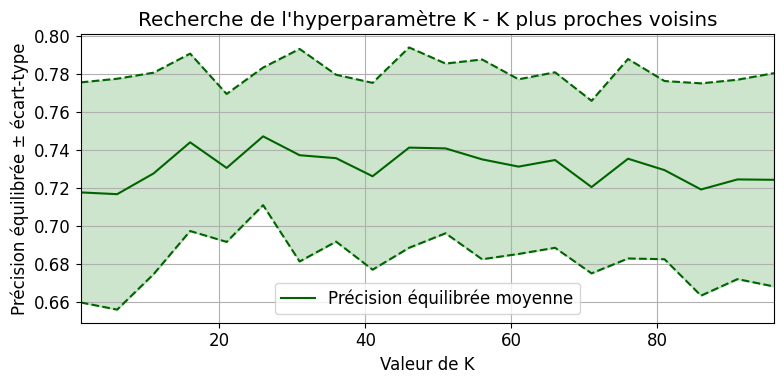

In [123]:
plt.figure(figsize=(8, 4))

# Moyenne et écart-type de la précision équilibrée pour chaque valeur de K
scores_moyens = grid_knn.cv_results_['mean_test_score']
ecart_type = grid_knn.cv_results_['std_test_score']
valeurs_k = grid_knn.cv_results_['param_n_neighbors'].data

# Tracé de la courbe principale et des bandes d'incertitude
plt.plot(valeurs_k, scores_moyens, label="Précision équilibrée moyenne", color='darkgreen')
plt.plot(valeurs_k, scores_moyens + ecart_type, linestyle='--', color='darkgreen')
plt.plot(valeurs_k, scores_moyens - ecart_type, linestyle='--', color='darkgreen')

# Remplissage de la zone entre +1σ et -1σ
plt.fill_between(valeurs_k, scores_moyens - ecart_type, scores_moyens + ecart_type,
                 color='green', alpha=0.2)

# Mise en forme du graphique
plt.xlabel("Valeur de K")
plt.ylabel("Précision équilibrée ± écart-type")
plt.title("Recherche de l'hyperparamètre K - K plus proches voisins")
plt.xlim([valeurs_k.min(), valeurs_k.max()])
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### Commentaires 
On observe que la précision équilibrée varie dans une plage relativement restreinte, entre 0,72 et 0,75.
Pour de faibles valeurs de K (inférieures à 18), la précision augmente rapidement : cela reflète un modèle trop simple au départ, qui gagne en performance en considérant plus de voisins.

Lorsque K est compris entre 18 et 35, la précision semble se stabiliser autour de 0,75, laissant supposer que cette plage contient la valeur optimale de K.
Au-delà, il semble y avoir une décroissance de la précision, surement due au fait que des voisins trop éloignés apportent du bruit plutôt que de l’information pertinente : on va chercher "trop loin".

Or, on a balayé les K de 5 en 5 pour obtenir ce graphique : on peut se permettre de se focaliser sur la zone entre K = 18 et K = 35 avec un "pas" de 1 entre chaque K testé :

In [94]:
# Nouvelle grille de K avec pas de 1, dans un intervalle de recherche restreint :
from sklearn.model_selection import GridSearchCV, KFold


K_range_fine = np.arange(15, 36, 1)

# Re-définition du validateur croisé
cv_folds = KFold(n_splits=10, shuffle=True, random_state=42) # on prend une seed qui permet d'avoir un resultat deterministe 

# Redéfinir le modèle KNN
knn_model = KNeighborsClassifier()

# Nouvelle recherche sur grille
grid_fine = GridSearchCV(knn_model,
                         param_grid={'n_neighbors': K_range_fine},
                         cv=cv_folds,
                         scoring='balanced_accuracy')

# Apprentissage sur les données standardisées
grid_fine.fit(X_scaled, y_train_risk_vs_norisk)

# Affichage des résultats optimaux
K_opt = grid_fine.best_params_['n_neighbors']
best_score = grid_fine.best_score_

print(f"Valeur optimale de K : {K_opt}")
print(f"Précision équilibrée correspondante : {best_score:.3f}")

Valeur optimale de K : 27
Précision équilibrée correspondante : 0.750


## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

Nous avons précédemment observé que certaines variables du jeu de données sont fortement corrélées entre elles, comme la pression systolique et la pression diastolique.

Or, la régularisation L1 (lasso), bien qu’elle favorise la parcimonie et l’interprétabilité du modèle, tend dans ces cas à éliminer arbitrairement l’une des deux variables corrélées en mettant son coefficient à zéro.
Dans cette analyse, nous ne cherchons pas à réduire la dimension du problème ni à améliorer l’interprétabilité, mais à maximiser les performances prédictives. La régularisation **L2** est donc mieux adaptée.

Pour la recherche de l’hyperparamètre C, qui correspond à l’inverse du coefficient de régularisation, pour "ratisser large", nous choisissons une grille logarithmique couvrant un grand interval de valeurs : $ C \in [10^{-4}, 10^4]$

Dans un premier temps, pour se donner des idées sur C, nous allons prendre 50 valeurs dans l'interval $ C \in [10^{-4}, 10^4]$, réparties log-uniformements (en effet : si pas log-uniforme : on risque de prendre des valeurs proches de 1), 

Pour éviter de prendre les 10 premieres valeurs de mon vecteur X, je vais mélanger les données :

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42) # La seed qui répond à toutes les questions


In [125]:
from sklearn.linear_model import LogisticRegression

# Définir la grille de valeurs de l'hyperparamètre alpha 
alphas = np.logspace(-4, 4, 50)

# Définir le modèle à évaluer
logireg = LogisticRegression('l2')

# Instantier la recherche sur grille
grid_logistic = model_selection.GridSearchCV(logireg, {'C': alphas}, 
                                    cv=kf, 
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid_logistic.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04])},
             scoring='balanced_accuracy')

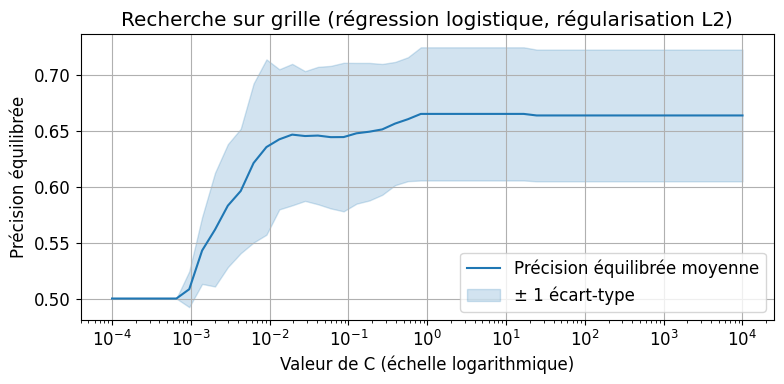

In [126]:
# Récupérer les résultats
precisions_moyennes = grid_logistic.cv_results_['mean_test_score']
ecarts_type = grid_logistic.cv_results_['std_test_score']
valeurs_C = grid_logistic.cv_results_['param_C'].data

# Tracer la courbe
plt.figure(figsize=(8, 4))
plt.semilogx(valeurs_C, precisions_moyennes, label='Précision équilibrée moyenne', color='tab:blue')
plt.fill_between(valeurs_C,
                 precisions_moyennes - ecarts_type,
                 precisions_moyennes + ecarts_type,
                 color='tab:blue',
                 alpha=0.2,
                 label='± 1 écart-type')

# Mise en forme
plt.xlabel("Valeur de C (échelle logarithmique)")
plt.ylabel("Précision équilibrée")
plt.title("Recherche sur grille (régression logistique, régularisation L2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Lorsque la valeur de C se rapproche de zéro — ce qui correspond à une régularisation très forte — le modèle privilégie tellement le terme de régularisation qu’il annule quasiment tous les coefficients. En conséquence, la fonction de décision devient constante, ce qui signifie que le modèle prédit toujours la même classe, quel que soit l’échantillon. Cela conduit à une précision équilibrée d’environ 0,5, car il attribue de façon aléatoire les étiquettes, aussi bien aux observations à risque qu’à celles sans risque.

À l’inverse, lorsque C devient très grand, la régularisation est quasi inexistante, et le modèle se rapproche d’une régression logistique classique non régularisée. 

Ainsi, le C qui nous interesse semble se situer entre ces deux zones.

En observant les résultats, on remarque que le meilleur équilibre se trouve pour une valeur de C comprise entre 0,1 et 100. Pour affiner la recherche, on va donc explorer cet intervalle avec des pas plus fins afin de déterminer précisément la valeur optimale de C.

In [127]:
# On prend bien une echelle log
alphas = np.logspace(-1, 2, 50) 

# Définir le modèle à évaluer
logireg = LogisticRegression('l2')

# Init recherche sur grille
grid_logistic = model_selection.GridSearchCV(logireg, {'C': alphas}, 
                                    cv= kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid_logistic.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': array([  0.1       ,   0.11513954,   0.13257114,   0.1526418 ,
         0.17575106,   0.20235896,   0.23299518,   0.26826958,
         0.30888436,   0.35564803,   0.40949151,   0.47148664,
         0.54286754,   0.62505519,   0.71968567,   0.82864277,
         0.95409548,   1.09854114,   1.26485522,   1.45634848,
         1.67683294,   1.93069773,   2.22299648,   2.55954792,
         2.9470517 ,   3.39322177,   3.90693994,   4.49843267,
         5.17947468,   5.96362332,   6.86648845,   7.90604321,
         9.10298178,  10.48113134,  12.06792641,  13.89495494,
        15.9985872 ,  18.42069969,  21.20950888,  24.42053095,
        28.11768698,  32.37457543,  37.2759372 ,  42.9193426 ,
        49.41713361,  56.89866029,  65.51285569,  75.43120063,
        86.85113738, 100.        ])},
             scoring='balanced_accuracy')

Valeur optimale de C trouvée : 0.7196856730011519
Précision équilibrée associée : 0.6654 ± 0.0597


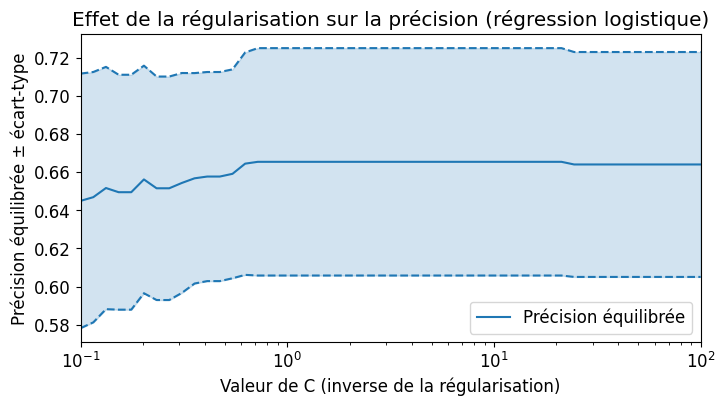

In [128]:
# Visualisation de l'impact de l'hyperparamètre C sur la précision équilibrée (régression logistique)

plt.figure(figsize=(8, 4))

# Récupération des scores moyens et de leur écart-type pour chaque valeur de C testée
balanced_accs = grid_logistic.cv_results_['mean_test_score']
std_devs = grid_logistic.cv_results_['std_test_score']

# Tracés des performances sur une échelle logarithmique pour C
plt.semilogx(grid_logistic.cv_results_['param_C'], balanced_accs, 
             label="Précision équilibrée", color='tab:blue')
plt.semilogx(grid_logistic.cv_results_['param_C'], balanced_accs + std_devs, 
             color='tab:blue', linestyle='--')
plt.semilogx(grid_logistic.cv_results_['param_C'], balanced_accs - std_devs, 
             color='tab:blue', linestyle='--')

# Visualisation de la zone de variation (±1 écart-type)
plt.fill_between(alphas, balanced_accs + std_devs, balanced_accs - std_devs, 
                 color='tab:blue', alpha=0.2)

# Mise en page du graphique
plt.xlabel("Valeur de C (inverse de la régularisation)")
plt.ylabel("Précision équilibrée ± écart-type")
plt.xlim([alphas[0], alphas[-1]])
plt.title("Effet de la régularisation sur la précision (régression logistique)")
plt.legend(loc='best')

# Affichage du meilleur résultat trouvé par la recherche sur grille
best_C = grid_logistic.best_params_['C']
best_score = grid_logistic.best_score_
best_std = std_devs[grid_logistic.best_index_]

print(f"Valeur optimale de C trouvée : {best_C}")
print(f"Précision équilibrée associée : {best_score:.4f} ± {best_std:.4f}")


## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

Nous choississons le modele de la forêt aléatoire. Deux hyperparamètres principaux sont à optimiser : le nombre d’arbres (n_estimators) et le critère utilisé pour évaluer la qualité des divisions aux nœuds (criterion). Il ne semble pas pertinent d’ajuster le nombre de variables à considérer à chaque division : avec seulement 6 variables d’entrée, la règle suggère d’en utiliser environ $\sqrt 6$, ce qui est raisonnable.

Pour le critere de division, nous comparerons les performances des critères “gini” et “entropy”. Le critère d’erreur quadratique est exclu car il ne s’applique qu’à la régression.

Pour le nombre d’arbres, nous commencerons par explorer un large intervalle (entre 5 et 100). Une fois la zone optimale repérée, nous pourrons affiner la recherche pour raffiner.

In [106]:
kf = KFold(n_splits=10, shuffle=True, random_state=42) #Encore une fois

In [109]:
from sklearn.ensemble import RandomForestClassifier

# Définition de la grille
params_rf = {'n_estimators': np.arange(5, 105, 5),  # de 5 à 100 par pas de 5
             'criterion': ['gini', 'entropy']}

# Modèle non linéaire adopté : foret aleatoire
rf = RandomForestClassifier(random_state=42)


# Recherche sur grille
grid_rf = GridSearchCV(rf, params_rf, cv=kf, scoring='balanced_accuracy', n_jobs=-1)
grid_rf.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])},
             scoring='balanced_accuracy')

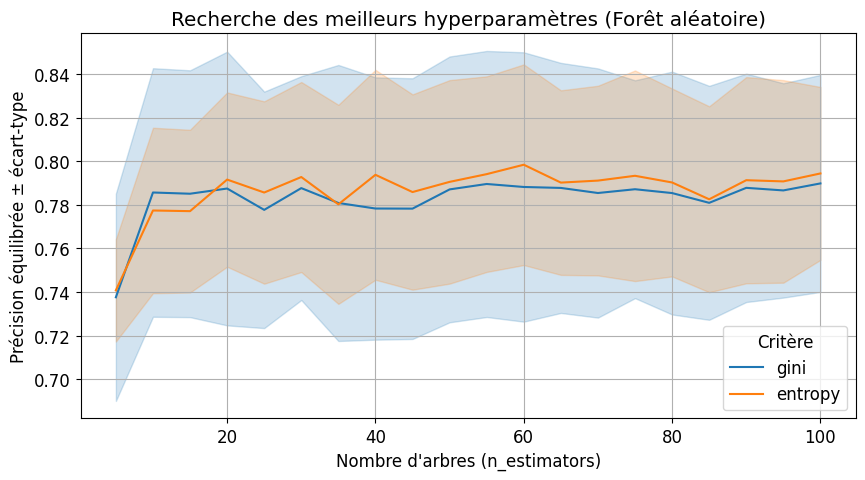

In [115]:
# Résultats dans un DataFrame
results = pd.DataFrame(grid_rf.cv_results_)

# Visualisation
plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', hue='param_criterion')
plt.fill_between(
    results[results['param_criterion'] == 'gini']['param_n_estimators'],
    results[results['param_criterion'] == 'gini']['mean_test_score'] - results[results['param_criterion'] == 'gini']['std_test_score'],
    results[results['param_criterion'] == 'gini']['mean_test_score'] + results[results['param_criterion'] == 'gini']['std_test_score'],
    alpha=0.2, color='tab:blue'
)
plt.fill_between(
    results[results['param_criterion'] == 'entropy']['param_n_estimators'],
    results[results['param_criterion'] == 'entropy']['mean_test_score'] - results[results['param_criterion'] == 'entropy']['std_test_score'],
    results[results['param_criterion'] == 'entropy']['mean_test_score'] + results[results['param_criterion'] == 'entropy']['std_test_score'],
    alpha=0.2, color='tab:orange'
)
plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Précision équilibrée ± écart-type")
plt.title("Recherche des meilleurs hyperparamètres (Forêt aléatoire)")
plt.legend(title="Critère")
plt.grid(True)
plt.show()


Les deux critères fournissent des resultats similaires dès qu’on utilise suffisamment d’arbres (environ une dizaine). Leurs résultats restent proches, à l’intérieur d’un écart-type, et la meilleure option change d’un fold à un autre en changeant la seed. Sans perte apparente de généralité, on va se pencher sur le critère "Gini".

Pour l’hyperparamètre N (nombre d’arbres), la précision équilibrée atteint son maximum entre 40 et 70 arbres. Nous nous concentrons sur la plage 40-70, où nous cherchons et affichons la valeur optimale Nopt ainsi que la précision correspondante.

In [129]:
# Définir la grille de valeurs des hyperparamètres n_estimators et criterion
Nb_estimators = np.arange(40, 71, 1)

# Définir le modèle à évaluer
forest = RandomForestClassifier()

# Instantier la recherche sur grille
grid_rf = model_selection.GridSearchCV(forest, {'n_estimators': Nb_estimators, 'criterion': ['gini']}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid_rf.fit(X_scaled, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'],
                         'n_estimators': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])},
             scoring='balanced_accuracy')

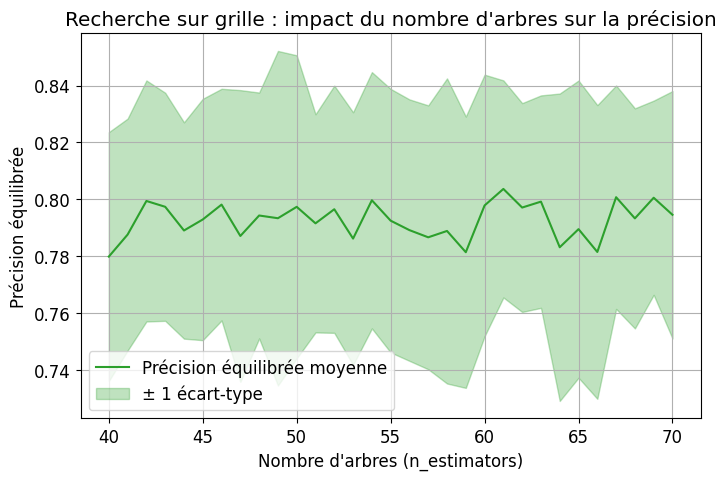

Valeur optimale de n_estimators : 61
Précision équilibrée associée : 0.8036 ± 0.0382
Meilleure performance : précision équilibrée = 0.8036 ± 0.0382 obtenue avec n_estimators = 61


In [130]:
# Récupération des résultats
mean_scores = grid_rf.cv_results_['mean_test_score']
std_scores = grid_rf.cv_results_['std_test_score']
n_estimators = grid_rf.cv_results_['param_n_estimators'].data.astype(int)

plt.figure(figsize=(8, 5))

# Tracer la précision équilibrée moyenne
plt.plot(n_estimators, mean_scores, label='Précision équilibrée moyenne', color='tab:green')

# Tracer les bandes ± un écart-type
plt.fill_between(n_estimators,
                 mean_scores - std_scores,
                 mean_scores + std_scores,
                 color='tab:green',
                 alpha=0.3,
                 label='± 1 écart-type')

plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Précision équilibrée")
plt.title("Recherche sur grille : impact du nombre d'arbres sur la précision")
plt.legend(loc='best')
plt.grid(True)

plt.show()

# Afficher la meilleure valeur, score et écart-type correspondant
best_n_estimators = grid_rf.best_params_['n_estimators']
best_index = grid_rf.best_index_
best_score = grid_rf.best_score_
best_std = std_scores[best_index]

print(f"Valeur optimale de n_estimators : {best_n_estimators}")
print(f"Précision équilibrée associée : {best_score:.4f} ± {best_std:.4f}")
print(f"Meilleure performance : précision équilibrée = {best_score:.4f} ± {best_std:.4f} obtenue avec n_estimators = {best_n_estimators}")


### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

In [132]:
# Récupération des meilleurs hyperparamètres et scores pour chaque modèle

# K plus proches voisins
best_k = grid_knn.best_params_['n_neighbors']
score_knn = grid_knn.best_score_
std_knn = grid_knn.cv_results_['std_test_score'][grid_knn.best_index_]

# Régression logistique
best_c = grid_logistic.best_params_['C']
score_logreg = grid_logistic.best_score_
std_logreg = grid_logistic.cv_results_['std_test_score'][grid_logistic.best_index_]

# Forêt aléatoire
best_n = grid_rf.best_params_['n_estimators']
score_rf = grid_rf.best_score_
std_rf = grid_rf.cv_results_['std_test_score'][grid_rf.best_index_]

# Construction du tableau récapitulatif
resultats_models = pd.DataFrame({
    "Modèle": [
        "K plus proches voisins",
        "Régression logistique",
        "Forêt aléatoire"
    ],
    "Hyperparamètre optimal": [
        f"K = {best_k}",
        f"C = {best_c}",
        f"N = {best_n}"
    ],
    "Précision équilibrée (± écart-type)": [
        f"{score_knn:.3f} ± {std_knn:.3f}",
        f"{score_logreg:.3f} ± {std_logreg:.3f}",
        f"{score_rf:.3f} ± {std_rf:.3f}"
    ]
})

display(resultats_models)


,Modèle,Hyperparamètre optimal,Précision équilibrée (± écart-type)
0,K plus proches voisins,K = 26,0.747 ± 0.036
1,Régression logistique,C = 0.7196856730011519,0.665 ± 0.060
2,Forêt aléatoire,N = 61,0.804 ± 0.038


La méthode de la Forêt aléatoire semble la plus efficace, avec la meilleure précision équilibrée et le meilleur écart-type. Cependant, il s'agit d'un algorithme non-linéaire, et il met plus de temps à s'executer de part sa complexité. Il semblerait que les K-plus-proches-voisins est une méthode viable pour ce problème.

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

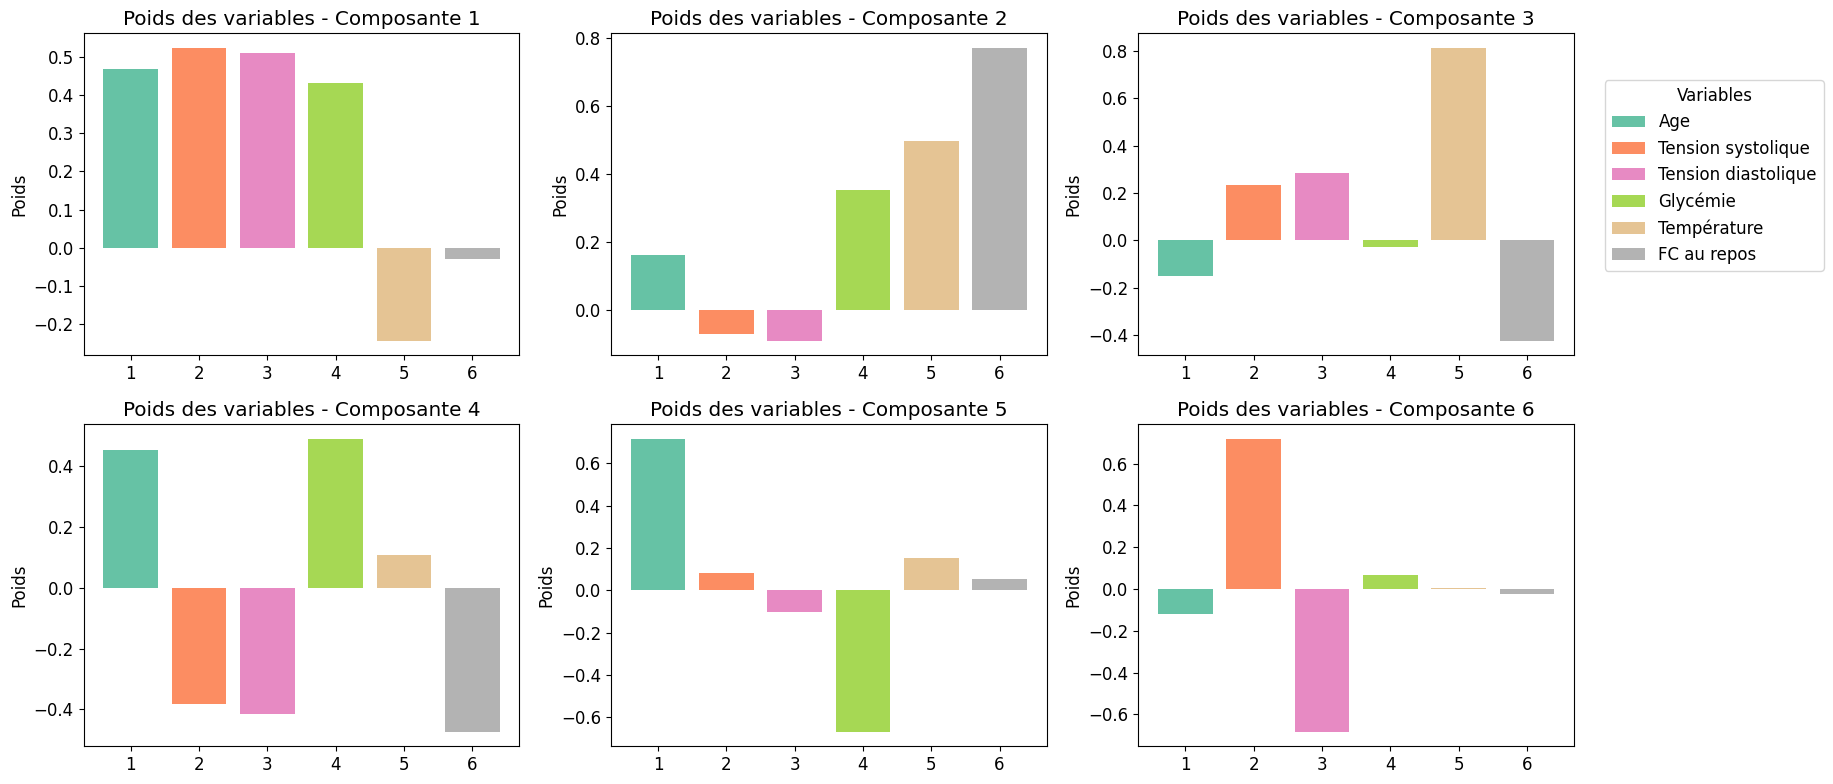

In [138]:
# Visualisation des poids des variables sur les 6 premières composantes principales

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()
palette = plt.cm.Set2(np.linspace(0, 1, 6))
noms_variables = df_train.columns[:-1]

for idx in range(6):
    ax = axes[idx]
    bars = ax.bar(np.arange(1, 7), pca.components_[idx], color=palette)
    ax.set_title(f"Poids des variables - Composante {idx + 1}")
    ax.set_ylabel("Poids")
    ax.set_xticks(np.arange(1, 7))

# Ajout d'une légende globale pour toutes les sous-figures
fig.legend(bars, noms_variables, 
           title="Variables",
           loc='upper right',
           bbox_to_anchor=(1.15, 0.9))

plt.tight_layout()


In [139]:
# Nouvelle matrice à 4 dimensions
from sklearn.decomposition import PCA

pca_4 = PCA(n_components=4)
X_pca4 = pca_4.fit_transform(X_scaled)

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

On repart sur la forêt aléatoire :

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Définition de la grille
params_rf = {'n_estimators': np.arange(5, 105, 10),  # de 5 à 100 par pas de 5
             'criterion': ['gini', 'entropy']}

# Modèle non linéaire adopté : foret aleatoire
rf = RandomForestClassifier(random_state=42)


# Recherche sur grille
grid_rf_pca4 = GridSearchCV(rf, params_rf, cv=kf, scoring='balanced_accuracy', n_jobs=-1)
grid_rf_pca4.fit(X_pca4, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])},
             scoring='balanced_accuracy')

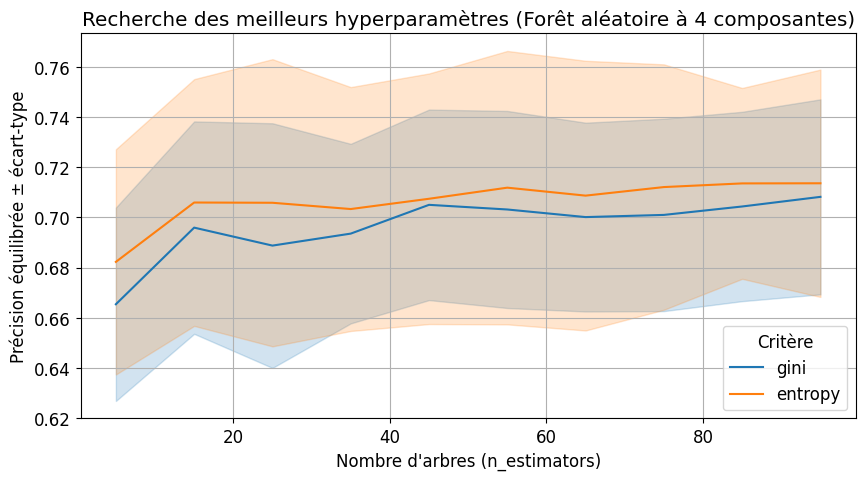

In [ ]:
# Résultats dans un DataFrame
results = pd.DataFrame(grid_rf_pca4.cv_results_)

# Visualisation
plt.figure(figsize=(10, 5))
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', hue='param_criterion')
plt.fill_between(
    results[results['param_criterion'] == 'gini']['param_n_estimators'],
    results[results['param_criterion'] == 'gini']['mean_test_score'] - results[results['param_criterion'] == 'gini']['std_test_score'],
    results[results['param_criterion'] == 'gini']['mean_test_score'] + results[results['param_criterion'] == 'gini']['std_test_score'],
    alpha=0.2, color='tab:blue'
)
plt.fill_between(
    results[results['param_criterion'] == 'entropy']['param_n_estimators'],
    results[results['param_criterion'] == 'entropy']['mean_test_score'] - results[results['param_criterion'] == 'entropy']['std_test_score'],
    results[results['param_criterion'] == 'entropy']['mean_test_score'] + results[results['param_criterion'] == 'entropy']['std_test_score'],
    alpha=0.2, color='tab:orange'
)
plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Précision équilibrée ± écart-type")
plt.title("Recherche des meilleurs hyperparamètres (Forêt aléatoire à 4 composantes)")
plt.legend(title="Critère")
plt.grid(True)
plt.show()


Passons à la phase de "rafinement", avec $n_{estimator} \in [40,60]$, sur le critère gini

In [147]:

# Définition de la grille
params_rf = {'n_estimators': np.arange(40, 60, 1),  # de 40 à 60 par pas de 1
             'criterion': ['gini']}

# Modèle non linéaire adopté : foret aleatoire
rf = RandomForestClassifier(random_state=42)


# Recherche sur grille
grid_rf_pca4 = GridSearchCV(rf, params_rf, cv=kf, scoring='balanced_accuracy', n_jobs=-1)
grid_rf_pca4.fit(X_pca4, y_train_risk_vs_norisk)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'n_estimators': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])},
             scoring='balanced_accuracy')

Et on trace le graphique :

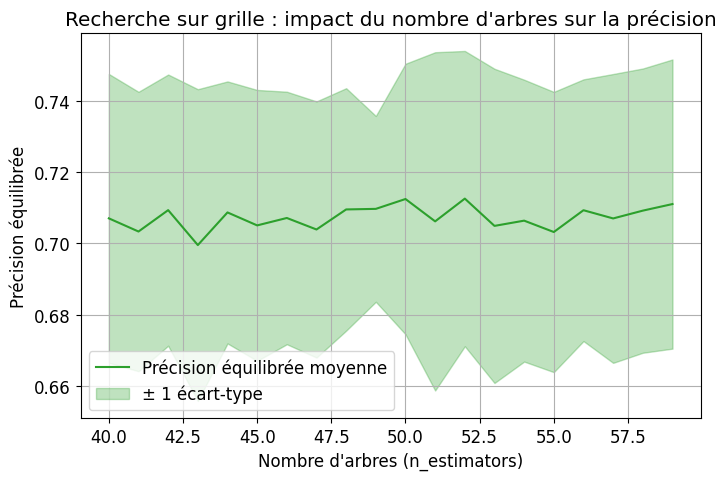

Valeur optimale de n_estimators : 60
Précision équilibrée associée : 0.7188 ± 0.0474
Meilleure performance : précision équilibrée = 0.7188 ± 0.0474 obtenue avec n_estimators = 60


In [149]:
# Récupération des résultats
mean_scores = grid_rf_pca4.cv_results_['mean_test_score']
std_scores = grid_rf_pca4.cv_results_['std_test_score']
n_estimators = grid_rf_pca4.cv_results_['param_n_estimators'].data.astype(int)

plt.figure(figsize=(8, 5))

# Tracer la précision équilibrée moyenne
plt.plot(n_estimators, mean_scores, label='Précision équilibrée moyenne', color='tab:green')

# Tracer les bandes ± un écart-type
plt.fill_between(n_estimators,
                 mean_scores - std_scores,
                 mean_scores + std_scores,
                 color='tab:green',
                 alpha=0.3,
                 label='± 1 écart-type')

plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Précision équilibrée")
plt.title("Recherche sur grille : impact du nombre d'arbres sur la précision")
plt.legend(loc='best')
plt.grid(True)

plt.show()

# Afficher la meilleure valeur, score et écart-type correspondant
best_n_estimators = grid_rf.best_params_['n_estimators']
best_index = grid_rf.best_index_
best_score = grid_rf.best_score_
best_std = std_scores[best_index]

print(f"Valeur optimale de n_estimators : {best_n_estimators}")
print(f"Précision équilibrée associée : {best_score:.4f} ± {best_std:.4f}")
print(f"Meilleure performance : précision équilibrée = {best_score:.4f} ± {best_std:.4f} obtenue avec n_estimators = {best_n_estimators}")


### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

In [150]:
# Récupération des meilleurs hyperparamètres avec et sans reduction de dimension

# Forêt aléatoire 
best_n = grid_rf.best_params_['n_estimators']
score_rf = grid_rf.best_score_
std_rf = grid_rf.cv_results_['std_test_score'][grid_rf.best_index_]

# Forêt aléatoire avec PCA
best_n_pca = grid_rf_pca4.best_params_['n_estimators']
score_rf_pca = grid_rf_pca4.best_score_
std_rf_pca = grid_rf_pca4.cv_results_['std_test_score'][grid_rf.best_index_]

# Construction du tableau récapitulatif
resultats_models = pd.DataFrame({
    "Modèle": [
        "Forêt aléatoire",
        "Forêt aléatoire avec PCA"
    ],
    "Hyperparamètre optimal": [
        f"N = {best_n}",
        f"N = {best_n_pca}"
    ],
    "Précision équilibrée (± écart-type)": [
        f"{score_rf:.3f} ± {std_rf:.3f}",
        f"{score_rf_pca:.3f} ± {std_rf_pca:.3f}"
    ]
})

display(resultats_models)


,Modèle,Hyperparamètre optimal,Précision équilibrée (± écart-type)
0,Forêt aléatoire,N = 60,0.719 ± 0.040
1,Forêt aléatoire avec PCA,N = 52,0.713 ± 0.047


Il y a une légère baisse de la précision lorsqu'on fait la PCA, mais cela reste sous l'écart-type. Cepandant, là où on perd un peu en précision, on le gagne en complexité : il est souhaitable de faire une PCA.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

On utilise la random forest, avec PCA : 

In [ ]:
Nopt = grid_rf.best_params_['n_estimators']
criterion_opt = grid_rf.best_params_['criterion']

final_binary_classifier = RandomForestClassifier(
    n_estimators=Nopt,
    criterion=criterion_opt,
    random_state=42
)
final_binary_classifier.fit(X_scaled, y_train_risk_vs_norisk)  # forêts aléatoires sans PCA

RandomForestClassifier(n_estimators=np.int64(60), random_state=42)

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [152]:
df_test = pd.read_csv('data/donnees_reservees.csv')
df_test['Risque'] = np.where(df_test['Risque'] == 2, 1, df_test['Risque'])

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

In [153]:
X_test = np.array(df_test.drop('Risque', axis=1))
X_test_scaled = std_scale.transform(X_test)  # on n'oublie pas de standardiser les variables

y_pred_test = final_binary_classifier.predict(X_test_scaled)

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

In [156]:
from sklearn.metrics import balanced_accuracy_score
# précision équilibrée sur le jeu de test
y_test = np.array(df_test['Risque'])
ba_test = balanced_accuracy_score(y_test, y_pred_test)
print(f"Précision équilibrée sur le jeu de test : {ba_test}")

# précision équilibrée obtenue en validation croisée
ba_cv = grid_rf.best_score_
std_cv = grid_rf.cv_results_['std_test_score'][grid_rf.best_index_]
print(f"Précision équilibrée en validation croisée : {ba_cv} ± {std_cv}")

Précision équilibrée sur le jeu de test : 0.8454595689813962
Précision équilibrée en validation croisée : 0.7187929041171965 ± 0.039886758505591396


### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

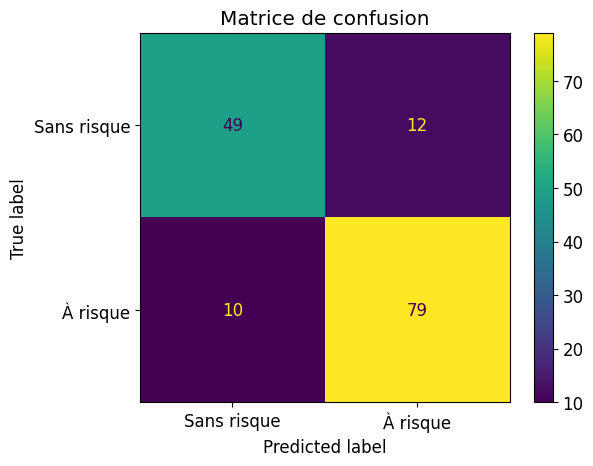

In [157]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=["Sans risque", "À risque"], colorbar= "veridis")
plt.title("Matrice de confusion")
plt.show()

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.